# 📘 05_geospatial_analysis.ipynb

Proyecto: Análisis del desempeño logístico y satisfacción del cliente en ecommerce (México)
Versión: v1

## Análisis Geoespacial

En este notebook se explora el comportamiento de los pedidos a nivel regional, observando cómo cambian algunos aspectos del proceso de entrega, como el tiempo promedio y la calificación de los clientes, según el estado (customer_state).

El objetivo es considerar el enfoque territorial en el análisis, no para obtener precisión geográfica exacta (ya que los datos de ubicación son sintéticos), sino para comparar regiones entre sí y detectar patrones generales en la experiencia de entrega y satisfacción.

Este ejercicio tiene un enfoque exploratorio y descriptivo, y busca mostrar una perspectiva comparativa que ayude a contextualizar los resultados obtenidos en notebooks anteriores y a orientar análisis posteriores más específicos.

## Carga de datos
En este primer paso se cargan los datasets necesarios para el análisis geográfico.
Se utiliza el dataset de pedidos ya enriquecido, junto con la información de clientes y el archivo de geolocalización, que contiene coordenadas y referencias espaciales por código postal.

El objetivo de esta sección es asegurar que la información esté disponible y correctamente integrada antes de explorar patrones regionales en tiempos de entrega, retrasos y calificaciones.
A partir de estos datos se construirá la base para los análisis por estado y las visualizaciones geográficas que se desarrollan más adelante.

In [26]:
# Importar librerías necesarias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Carga de datasets
path = "https://raw.githubusercontent.com/RaquelGlez/ecommerce_report/refs/heads/main/data/processed/"

orders = pd.read_csv(path + 'orders_enriched.csv')
geo = pd.read_csv(path + 'geo_clean.csv')
customers = pd.read_csv(path + 'customers_clean.csv')

# Vista rápida del contenido
print(f"Orders: {orders.shape} | Customers: {customers.shape}")

# Vista inicial
orders.head()

Orders: (3000, 16) | Customers: (3000, 5)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delay_vs_estimate,is_late,purchase_day,purchase_month,week_of_year,order_total_value,review_score
0,ord_7370c26ead3d3cc6cee4f0548b8d,cus_3b0234601c0276e6cd4e08b6ae67,shipped,2025-08-16 21:12:27.948040,2025-08-16 23:12:27.948040,2025-08-17 23:12:27.948040,NaN,2025-08-24 23:12:27.948040,NaN,NaN,NaN,Saturday,August,33,4949.98,3
1,ord_079072dd7970d40a3922a6b0c459,cus_24cb3fa4569c4fd058f954f2e6f9,delivered,2024-12-12 02:52:21.349382,2024-12-12 05:52:21.349382,2024-12-14 05:52:21.349382,2024-12-15 05:52:21.349382,2024-12-15 05:52:21.349382,3.0,0.0,0.0,Thursday,December,50,1276.09,4
2,ord_2600b1cb6f6a38610007a8c9142c,cus_67a2c2db5bd7dc2f06a8f9b40226,delivered,2025-06-13 03:04:55.053859,2025-06-13 19:04:55.053859,2025-06-16 19:04:55.053859,2025-06-21 19:04:55.053859,2025-06-21 19:04:55.053859,8.0,0.0,0.0,Friday,June,24,2137.68,4
3,ord_aaa7c4626ea7ea636e5bba7afebd,cus_2b70a9c550bfd5e065a756e9fe9b,delivered,2025-04-26 01:55:37.919760,2025-04-26 08:55:37.919760,2025-04-27 08:55:37.919760,2025-04-28 08:55:37.919760,2025-04-29 08:55:37.919760,2.0,-1.0,0.0,Saturday,April,17,989.99,3
4,ord_0ca0641b834ceb0a46f85637e125,cus_36ba5c7d572c22a6650f11e37f4d,delivered,2025-06-21 18:52:40.013157,2025-06-21 21:52:40.013157,2025-06-22 21:52:40.013157,2025-06-25 21:52:40.013157,2025-06-27 21:52:40.013157,4.0,-2.0,0.0,Saturday,June,25,4403.75,3


## Análisis descriptivo por región
En este paso se resume la información de los pedidos a nivel estatal. Para cada estado (customer_state) se agrupan indicadores clave de volumen, desempeño logístico y satisfacción del cliente.<br>
El objetivo es obtener una primera comparación regional que permita observar si existen diferencias relevantes entre estados, sin entrar aún en explicaciones causales.

In [27]:
orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time_days', 'delay_vs_estimate', 'is_late', 'purchase_day',
       'purchase_month', 'week_of_year', 'order_total_value', 'review_score'],
      dtype='object')

In [28]:
customers.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [29]:
orders = orders.merge(
    customers[['customer_id', 'customer_state']],
    on='customer_id',
    how='left'
)

In [30]:
# Agrupar indicadores por estado

regional_summary = (
    orders.groupby('customer_state')
      .agg({
          'order_id': 'count',
          'delivery_time_days': 'mean',
          'delay_vs_estimate': 'mean',
          'is_late': 'mean',
          'review_score': 'mean'
      })
      .rename(columns={
          'order_id': 'num_orders',
          'delivery_time_days': 'avg_delivery_days',
          'delay_vs_estimate': 'avg_delay_days',
          'is_late': 'prop_late_orders',
          'review_score': 'avg_review_score'
      })
      .reset_index()
)

regional_summary.head()


,customer_state,num_orders,avg_delivery_days,avg_delay_days,prop_late_orders,avg_review_score
0,Aguascalientes,115,5.231707,-1.487805,0.0,3.860870
1,Baja California,91,5.213115,-1.590164,0.0,3.857143
2,Baja California Sur,104,5.333333,-1.243590,0.0,3.788462
3,Campeche,82,5.177419,-1.548387,0.0,3.865854
4,Chiapas,104,4.971014,-1.507246,0.0,3.932692


La tabla resultante muestra, para cada estado:

- El número total de pedidos registrados.
- El tiempo promedio de entrega.
- El retraso promedio respecto a la fecha estimada.
- La proporción de pedidos entregados tarde.
- La calificación promedio de los clientes.

A partir de esta vista se observa que, en general, los tiempos promedio de entrega son relativamente similares entre estados, con variaciones moderadas de décimas de día. Los retrasos promedio suelen ser negativos, lo que indica que muchos pedidos llegaron antes de la fecha estimada, y la proporción de pedidos con retraso es baja o nula en la mayoría de los estados.

En cuanto a la satisfacción, las calificaciones promedio se concentran en un rango estrecho, lo que sugiere una experiencia relativamente homogénea a nivel regional en este dataset. Esta tabla funciona como base para las visualizaciones geográficas posteriores, donde estas diferencias se analizan de forma más intuitiva y visual.

## Visualizaciones regionales


### Comparación regional del tiempo promedio de entrega

En esta sección se incorpora una perspectiva regional al análisis, con el objetivo de comparar cómo se comportan los pedidos entre distintos estados.

Dado que los datos de geolocalización son sintéticos y las coordenadas no representan ubicaciones reales con precisión, el análisis no se centra en la ubicación exacta sobre el mapa, sino en la comparación agregada por estado.

Para ello, se combinan los datos de los pedidos con información regional y se utilizan visualizaciones resumidas, como tablas comparativas y heatmaps, que permiten observar diferencias en los tiempos promedio de entrega y otros aspectos del proceso de envío, sin asumir una correspondencia geográfica exacta.

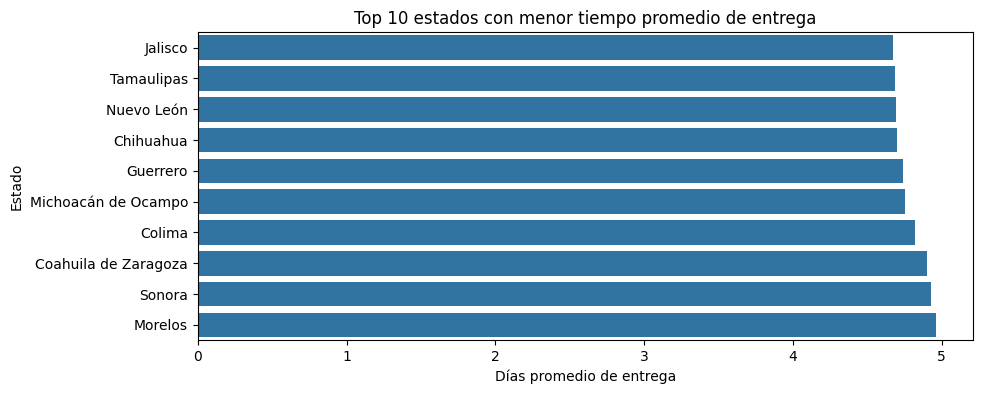

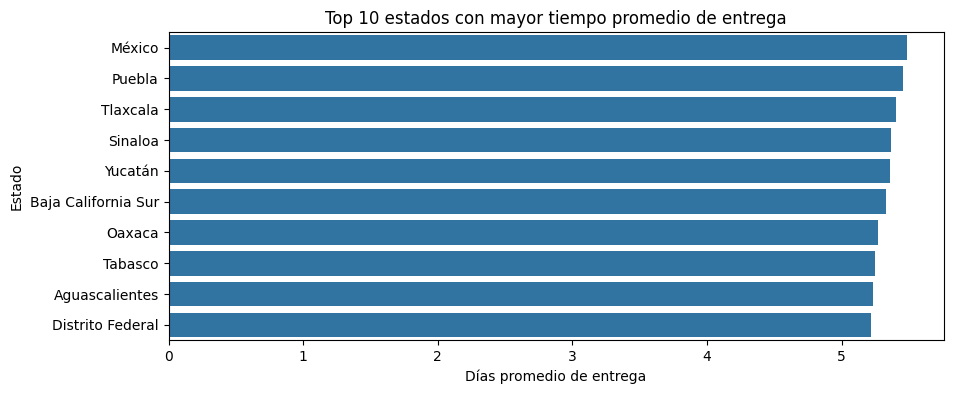

In [31]:
# Top 10 estados con menor tiempo promedio de entrega
top_fast = regional_summary.sort_values('avg_delivery_days').head(10)

# Top 10 estados con mayor tiempo promedio de entrega
top_slow = regional_summary.sort_values('avg_delivery_days', ascending=False).head(10)

plt.figure(figsize=(10,4))
sns.barplot(x='avg_delivery_days', y='customer_state', data=top_fast)
plt.title('Top 10 estados con menor tiempo promedio de entrega')
plt.xlabel('Días promedio de entrega')
plt.ylabel('Estado')
plt.show()

plt.figure(figsize=(10,4))
sns.barplot(x='avg_delivery_days', y='customer_state', data=top_slow)
plt.title('Top 10 estados con mayor tiempo promedio de entrega')
plt.xlabel('Días promedio de entrega')
plt.ylabel('Estado')
plt.show()


Estas visualizaciones muestran una comparación simple entre los estados con menor y mayor tiempo promedio de entrega, lo que permite identificar diferencias regionales sin depender de coordenadas geográficas que, en este dataset sintético, no representan ubicaciones reales.

En el gráfico de los 10 estados con menor tiempo promedio de entrega, se observan entidades donde los pedidos llegan de forma más rápida en promedio. Esto sugiere que, dentro del contexto del dataset, existen regiones donde el proceso de envío es más ágil o consistente.

Por otro lado, el gráfico de los 10 estados con mayor tiempo promedio de entrega muestra aquellos donde los pedidos tardan más en completarse. Aunque las diferencias entre estados no son extremas, sí se aprecia una variación suficiente para distinguir zonas con entregas relativamente más lentas.

En conjunto, estos resultados permiten:

- Comparar el comportamiento de los tiempos de entrega entre distintas regiones.
- Detectar estados que podrían requerir mayor atención en términos de tiempos de envío.
- Entender que, aun sin grandes contrastes, existen diferencias regionales en la experiencia de entrega.

Este tipo de análisis resulta especialmente útil como una primera aproximación regional, sin asumir causalidades ni conclusiones operativas.

## Integración de información geográfica

Para poder explorar diferencias regionales en los tiempos de entrega y la experiencia del cliente, en este paso se combinan los datasets de pedidos (orders_enriched.csv) y geolocalización (geo_clean.csv).
La unión se realiza a nivel de estado (customer_state), incorporando coordenadas promedio que permiten agregar una dimensión espacial al análisis.

Es importante aclarar que las coordenadas disponibles son sintéticas y no representan ubicaciones reales precisas. Por ello, este ejercicio no busca exactitud geográfica, sino construir una base comparativa por estado que permita observar tendencias generales en aspectos como:

- cantidad de pedidos,
- tiempo promedio de entrega,
- diferencias frente a la fecha estimada,
- proporción de pedidos con retraso,
- calificación promedio de los clientes.

Con esta información consolidada, se obtiene un resumen regional más completo que sirve como insumo para visualizaciones comparativas y mapas exploratorios, evitando interpretaciones erróneas sobre localizaciones específicas y enfocándose en patrones a nivel estado.

In [32]:
# Unir la información de pedidos con coordenadas

# Asegurar que ambos tengan la columna de referencia 'customer_state'
geo_states = (
    geo[['geolocation_state', 'geolocation_lat', 'geolocation_lng']]
      .groupby('geolocation_state')
      .mean()
      .reset_index()
      .rename(columns={
          'geolocation_state': 'customer_state',
          'geolocation_lat': 'lat',
          'geolocation_lng': 'lng'
      })
)

# Fusionar con el dataset principal
df_geo_merged = pd.merge(orders, geo_states, on='customer_state', how='left')

print("Dataset con coordenadas:", df_geo_merged.shape)
df_geo_merged.head()


Dataset con coordenadas: (3000, 19)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,delivery_time_days,delay_vs_estimate,is_late,purchase_day,purchase_month,week_of_year,order_total_value,review_score,customer_state,lat,lng
0,ord_7370c26ead3d3cc6cee4f0548b8d,cus_3b0234601c0276e6cd4e08b6ae67,shipped,2025-08-16 21:12:27.948040,2025-08-16 23:12:27.948040,2025-08-17 23:12:27.948040,NaN,2025-08-24 23:12:27.948040,NaN,NaN,NaN,Saturday,August,33,4949.98,3,Guanajuato,24.053236,-101.695039
1,ord_079072dd7970d40a3922a6b0c459,cus_24cb3fa4569c4fd058f954f2e6f9,delivered,2024-12-12 02:52:21.349382,2024-12-12 05:52:21.349382,2024-12-14 05:52:21.349382,2024-12-15 05:52:21.349382,2024-12-15 05:52:21.349382,3.0,0.0,0.0,Thursday,December,50,1276.09,4,Tabasco,23.559641,-101.817571
2,ord_2600b1cb6f6a38610007a8c9142c,cus_67a2c2db5bd7dc2f06a8f9b40226,delivered,2025-06-13 03:04:55.053859,2025-06-13 19:04:55.053859,2025-06-16 19:04:55.053859,2025-06-21 19:04:55.053859,2025-06-21 19:04:55.053859,8.0,0.0,0.0,Friday,June,24,2137.68,4,Morelos,23.792249,-102.389690
3,ord_aaa7c4626ea7ea636e5bba7afebd,cus_2b70a9c550bfd5e065a756e9fe9b,delivered,2025-04-26 01:55:37.919760,2025-04-26 08:55:37.919760,2025-04-27 08:55:37.919760,2025-04-28 08:55:37.919760,2025-04-29 08:55:37.919760,2.0,-1.0,0.0,Saturday,April,17,989.99,3,Guerrero,23.383400,-101.802273
4,ord_0ca0641b834ceb0a46f85637e125,cus_36ba5c7d572c22a6650f11e37f4d,delivered,2025-06-21 18:52:40.013157,2025-06-21 21:52:40.013157,2025-06-22 21:52:40.013157,2025-06-25 21:52:40.013157,2025-06-27 21:52:40.013157,4.0,-2.0,0.0,Saturday,June,25,4403.75,3,Baja California Sur,23.182925,-101.516095


In [33]:
df_geo_merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'delivery_time_days', 'delay_vs_estimate', 'is_late', 'purchase_day',
       'purchase_month', 'week_of_year', 'order_total_value', 'review_score',
       'customer_state', 'lat', 'lng'],
      dtype='object')

In [34]:
df_geo_merged['is_late'].unique()

array([nan,  0.])

## Proporción de pedidos con retraso por estado

Para complementar el análisis por tiempos promedio de entrega, en esta sección se analiza qué tan frecuentes son los retrasos en cada estado, independientemente de cuántos días dure la entrega en promedio.

La proporción de pedidos con retraso permite identificar regiones donde los incumplimientos en la fecha estimada son más comunes, lo cual aporta una perspectiva distinta a la del tiempo promedio y ayuda a detectar patrones generales en la experiencia de entrega por estado.

Dado que las coordenadas del dataset son sintéticas, este análisis se apoya en agregaciones por estado en lugar de mapas, priorizando la comparación clara entre regiones.

In [35]:
# Proporción de pedidos con retraso por estado
late_by_state = (
    df_geo_merged
    .groupby('customer_state')
    .agg(
        num_orders=('order_id', 'count'),
        prop_late_orders=('is_late', 'mean')
    )
    .reset_index()
    .sort_values('prop_late_orders', ascending=False)
)


In [36]:
late_by_state.head(10)

,customer_state,num_orders,prop_late_orders
0,Aguascalientes,115,0.0
1,Baja California,91,0.0
2,Baja California Sur,104,0.0
3,Campeche,82,0.0
4,Chiapas,104,0.0
5,Chihuahua,95,0.0
6,Coahuila de Zaragoza,100,0.0
7,Colima,95,0.0
8,Distrito Federal,85,0.0
9,Durango,103,0.0


En este caso, la proporción de pedidos con retraso es igual a cero en todos los estados. Esto se debe a la naturaleza sintética del dataset, en el que no se generaron entregas fuera de la fecha estimada. Por esta razón, la visualización no muestra variaciones entre regiones ni aporta información adicional al análisis en este contexto.

Aun así, se incluye este resultado como parte del ejercicio, ya que con datos reales este indicador suele ser muy útil para identificar diferencias regionales en la puntualidad de las entregas y complementar el análisis del tiempo promedio de entrega.

Dado que la variable de retrasos no aporta variabilidad en este dataset, el análisis se desplaza hacia otro indicador relevante de la experiencia del cliente: la calificación promedio otorgada en cada estado.

## Calificación promedio del cliente por estado

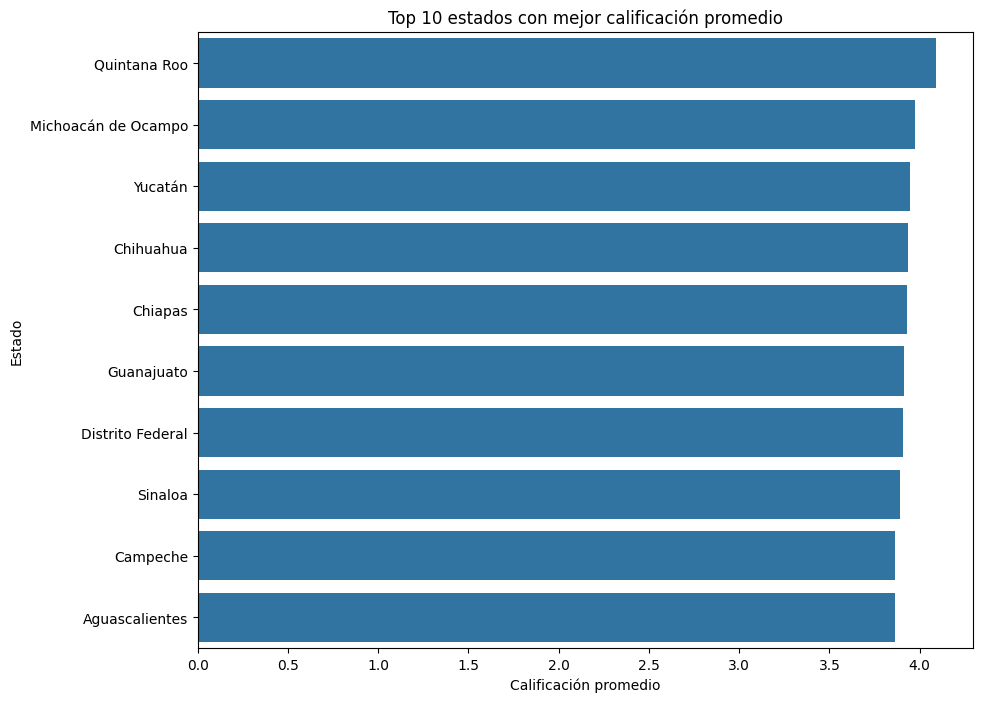

In [37]:
avg_review_by_state = (
    df_geo_merged
    .groupby('customer_state')['review_score']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=avg_review_by_state.head(10),
    x='review_score',
    y='customer_state'
)
plt.title('Top 10 estados con mejor calificación promedio')
plt.xlabel('Calificación promedio')
plt.ylabel('Estado')
plt.show()


En este grafico vemos los 10 estados con mejor calificación promedio por parte de los clientes. Aunque no se observan diferencias extremas entre estados, sí se aprecian ligeras variaciones que sugieren que la percepción del servicio no es completamente homogénea a nivel regional. Este resultado indica que, aun cuando los tiempos de entrega son similares y no hay retrasos registrados, la satisfacción del cliente puede estar influida por otros factores locales, como expectativas, calidad del servicio recibido o experiencia general de compra.
En un escenario con datos reales, este tipo de visualización sería útil para detectar regiones con una percepción consistentemente más positiva o negativa del servicio y orientar análisis más detallados.

Para complementar las métricas de tiempos y calificaciones, a continuación se analiza el volumen de pedidos por estado, lo que ayuda a entender el peso relativo de cada región dentro del dataset.

## Número de pedidos por estado

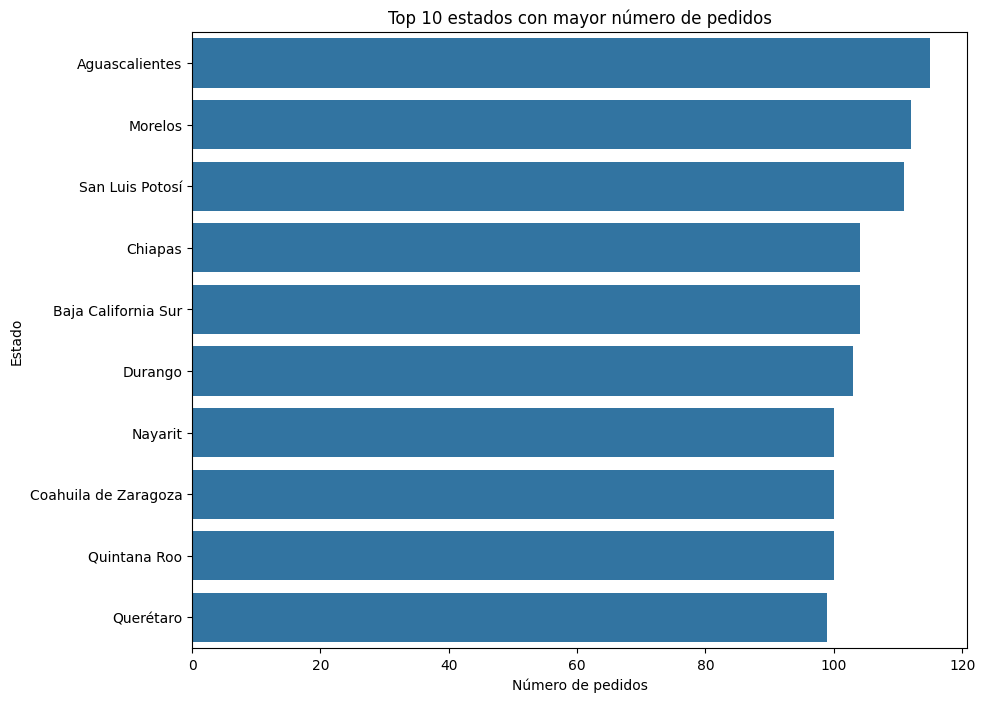

In [38]:
orders_by_state = (
    df_geo_merged
    .groupby('customer_state')['order_id']
    .count()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={'order_id': 'num_orders'})
)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=orders_by_state.head(10),
    x='num_orders',
    y='customer_state'
)
plt.title('Top 10 estados con mayor número de pedidos')
plt.xlabel('Número de pedidos')
plt.ylabel('Estado')
plt.show()


El gráfico muestra los 10 estados con mayor número de pedidos, lo cual aporta contexto clave para interpretar el resto de los análisis regionales. Se observa que algunos estados concentran una mayor parte de la demanda, mientras que otros tienen una participación mucho menor. Esto es relevante porque estados con más pedidos tienden a ofrecer métricas más estables y representativas, mientras que en estados con bajo volumen pequeñas variaciones pueden generar cambios aparentes más grandes en promedios. En este sentido, el volumen de pedidos ayuda a poner en perspectiva los resultados de tiempos de entrega y calificaciones observados previamente.

Ahora se analiza si existe alguna relación visible entre el tiempo promedio de entrega y la calificación promedio de los clientes cuando se observa la información a nivel estado.

## Relación simple → tiempo promedio vs calificación por estado

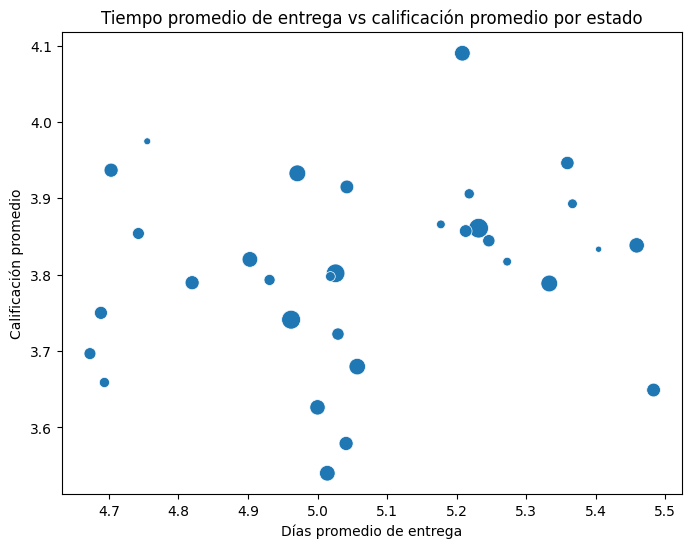

In [39]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=regional_summary,
    x='avg_delivery_days',
    y='avg_review_score',
    size='num_orders',
    sizes=(20, 200),
    legend=False
)
plt.title('Tiempo promedio de entrega vs calificación promedio por estado')
plt.xlabel('Días promedio de entrega')
plt.ylabel('Calificación promedio')
plt.show()


Para esta visualización
- No se observa una relación lineal clara entre el tiempo promedio de entrega y la calificación promedio: estados con tiempos de entrega similares muestran niveles de satisfacción distintos.
- Las calificaciones se mantienen relativamente estables (alrededor de 3.6 a 4.1) incluso cuando los días promedio de entrega varían, lo que sugiere que pequeñas diferencias en tiempos no impactan de forma directa la percepción del cliente.
- Algunos estados con tiempos de entrega más largos no necesariamente presentan peores calificaciones, lo que indica que otros factores (como expectativas, comunicación o experiencia general) podrían influir más en la evaluación del cliente.
- La dispersión de puntos refuerza la idea de una relación débil, más que de una dependencia directa entre rapidez de entrega y satisfacción.
- El tamaño similar de las observaciones (al tratarse de promedios por estado) ayuda a comparar regiones de forma homogénea, pero también limita la detección de patrones más finos.
- En el contexto de este dataset sintético, el gráfico es útil para descartar hipótesis simples, como asumir que entregar más rápido siempre se traduce en mejores calificaciones.

En conjunto, esta visualización sugiere que la satisfacción del cliente no depende únicamente del tiempo de entrega promedio, sino de una combinación de factores que no se capturan completamente en este análisis agregado.

## Resumen regional de métricas clave
Como complemento a las visualizaciones anteriores, se presenta una tabla resumen con los principales indicadores agregados por estado.

Esta vista permite comparar de forma directa el volumen de pedidos, los tiempos promedio de entrega y la satisfacción de los clientes entre distintas regiones, sin depender de representaciones geográficas que, en este caso, pueden resultar confusas debido a la naturaleza sintética de las coordenadas.

La tabla facilita una lectura clara de las diferencias generales entre estados y sirve como punto de referencia para identificar patrones o comportamientos que podrían explorarse con mayor profundidad en un análisis posterior.

In [40]:
# Resumen regional
regional_table = regional_summary[[
    'customer_state',
    'num_orders',
    'avg_delivery_days',
    'avg_delay_days',
    'prop_late_orders',
    'avg_review_score'
]].sort_values('num_orders', ascending=False)

regional_table_formatted = regional_table.copy()

regional_table_formatted['avg_delivery_days'] = regional_table_formatted['avg_delivery_days'].round(2)
regional_table_formatted['avg_delay_days'] = regional_table_formatted['avg_delay_days'].round(2)
regional_table_formatted['prop_late_orders'] = (regional_table_formatted['prop_late_orders'] * 100).round(1)
regional_table_formatted['avg_review_score'] = regional_table_formatted['avg_review_score'].round(2)

regional_table_formatted.head(10)


,customer_state,num_orders,avg_delivery_days,avg_delay_days,prop_late_orders,avg_review_score
0,Aguascalientes,115,5.23,-1.49,0.0,3.86
15,Morelos,112,4.96,-1.66,0.0,3.74
23,San Luis Potosí,111,5.03,-1.88,0.0,3.80
4,Chiapas,104,4.97,-1.51,0.0,3.93
2,Baja California Sur,104,5.33,-1.24,0.0,3.79
9,Durango,103,5.06,-1.40,0.0,3.68
17,Nayarit,100,5.01,-1.52,0.0,3.54
6,Coahuila de Zaragoza,100,4.90,-1.42,0.0,3.82
22,Quintana Roo,100,5.21,-1.33,0.0,4.09
21,Querétaro,99,5.00,-1.45,0.0,3.63


El análisis por estado permitió observar diferencias en el volumen de pedidos y en los tiempos promedio de entrega, ofreciendo una primera referencia sobre cómo se comportan estas métricas a nivel regional.

Dado que se trabaja con un dataset sintético, las coordenadas geográficas no representan ubicaciones reales precisas. Por este motivo, las visualizaciones espaciales se utilizaron con un enfoque comparativo, y no como una representación geográfica exacta del territorio.

La visualización de Top 10 y Bottom 10 estados por tiempo promedio de entrega resultó más informativa que los mapas, ya que permitió identificar con mayor claridad qué regiones presentan entregas relativamente más rápidas o más lentas.

La proporción de pedidos con retraso (prop_late_orders) fue cero en todos los estados, lo cual es consistente con la naturaleza de los datos generados.
En un escenario real, este indicador suele mostrar variaciones relevantes entre regiones y es clave para detectar posibles áreas con problemas operativos.

Otras métricas analizadas por estado, como el tiempo promedio de entrega, la diferencia frente a la fecha estimada y la calificación promedio de los clientes, permitieron explorar tendencias generales, aunque sin contrastes marcados entre regiones.

La tabla resumen por estado se consolidó como una alternativa más adecuada frente a visualizaciones geográficas complejas, ya que concentra la información clave y facilita la comparación directa entre regiones.

En conjunto, este notebook cumple un rol exploratorio y descriptivo: establece una base metodológica para futuros análisis con datos reales, donde los patrones geográficos suelen ser más claros y accionables.

### Exportación de datasets enriquecidos

Durante el desarrollo original del proyecto, este notebook generó una versión enriquecida del dataset de pedidos que incorporaba información geográfica adicional.  
El resultado de este proceso fue almacenado como archivos CSV para su reutilización en análisis posteriores.

En la versión actual del proyecto, estos datasets ya se encuentran versionados dentro del repositorio de GitHub en la carpeta `data/processed`.  
Por este motivo, el bloque de guardado de archivos se conserva únicamente como referencia del proceso seguido y no se ejecuta nuevamente al correr el notebook.


In [41]:
#output_path = "/content/drive/MyDrive/ecommerce_project/data/processed/orders_enriched.csv"
#df_geo_merged.to_csv(output_path, index=False)

#output_path = "/content/drive/MyDrive/ecommerce_project/data/processed/orders_geo_enriched.csv"
#df_geo_merged.to_csv(output_path, index=False)

